# Intestinal organoid differentiation - RNA velocity with EM model

Estimates RNA velocity with scVelo's _EM model_ and analyses corresponding fate mapping.

## Library imports

In [71]:
import os
import sys

import numpy as np
import pandas as pd

import cellrank as cr
import scanpy as sc
import scvelo as scv

from cr2 import (
    get_state_purity,
    get_var_ranks,
    plot_state_purity,
    plot_states,
    running_in_notebook,
)

sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

## General settings

In [72]:
sc.settings.verbosity = 3
scv.settings.verbosity = 3
cr.settings.verbosity = 2

In [73]:
scv.settings.set_figure_params("scvelo")

In [74]:
SAVE_FIGURES = False

if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "labeling_kernel", exist_ok=True)

## Constants

In [75]:
N_JOBS = 8

## Data loading

In [76]:
adata = sc.read(DATA_DIR / "sceu_organoid" / "processed" / "raw.h5ad")

adata = adata[adata.obs["labeling_time"] != "dmso", :].copy()
adata = adata[~adata.obs["cell_type"].isin(["Tuft cells"]), :]
adata.obs["labeling_time"] = adata.obs["labeling_time"].astype(float) / 60

adata.layers["unspliced"] = adata.layers["unlabeled_unspliced"] + adata.layers["labeled_unspliced"]
adata.layers["spliced"] = adata.layers["unlabeled_spliced"] + adata.layers["labeled_spliced"]

umap_coord_df = pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "umap_coords.csv", index_col=0)
umap_coord_df.index = umap_coord_df.index.astype(str)
adata.obsm["X_umap"] = umap_coord_df.loc[adata.obs_names, :].values
del umap_coord_df

adata

/tmp/ipykernel_867846/2797837506.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["labeling_time"] = adata.obs["labeling_time"].astype(float) / 60


AnnData object with n_obs × n_vars = 3452 × 9157
    obs: 'experiment', 'labeling_time', 'cell_type', 'well_id', 'batch_id', 'log10_gfp', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime'
    var: 'ensum_id'
    uns: 'cell_type_colors'
    obsm: 'X_umap_paper', 'X_umap'
    layers: 'labeled', 'labeled_spliced', 'labeled_unspliced', 'total', 'unlabeled', 'unlabeled_spliced', 'unlabeled_unspliced', 'unspliced', 'spliced'

## Data preprocessing

In [77]:
adata.obs["cell_type_merged"] = adata.obs["cell_type"].copy()
adata.obs["cell_type_merged"].replace({"Enteroendocrine cells": "Enteroendocrine progenitors"}, inplace=True)

In [78]:
# filter s.t. at least `min_counts` per labeling time point?
scv.pp.filter_and_normalize(
    adata,
    min_counts=50,
    layers_normalize=["X", "labeled", "unlabeled", "total", "unspliced", "spliced"],
    n_top_genes=2000,
)
adata

Filtered out 736 genes that are detected 50 counts (spliced).
Normalized count data: X, labeled, unlabeled, total, unspliced, spliced.
Extracted 2000 highly variable genes.
Logarithmized X.


AnnData object with n_obs × n_vars = 3452 × 2000
    obs: 'experiment', 'labeling_time', 'cell_type', 'well_id', 'batch_id', 'log10_gfp', 'som_cluster_id', 'monocle_branch_id', 'monocle_pseudotime', 'cell_type_merged', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'ensum_id', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'cell_type_colors'
    obsm: 'X_umap_paper', 'X_umap'
    layers: 'labeled', 'labeled_spliced', 'labeled_unspliced', 'total', 'unlabeled', 'unlabeled_spliced', 'unlabeled_unspliced', 'unspliced', 'spliced'

In [79]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)

scv.pp.moments(adata, n_neighbors=None, n_pcs=None)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


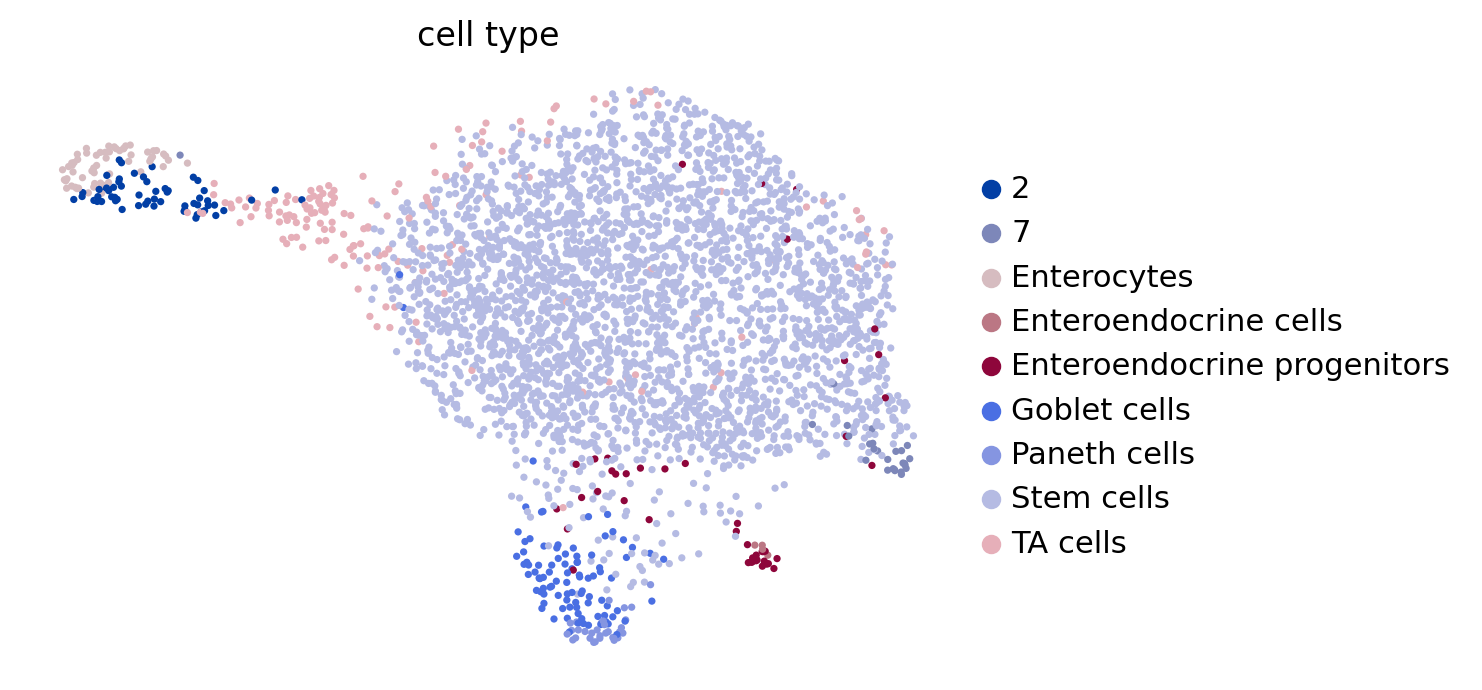

In [80]:
if running_in_notebook():
    scv.pl.scatter(adata, basis="umap", color="cell_type", legend_loc="right")

## Parameter inference

In [81]:
scv.tl.recover_dynamics(adata, n_jobs=N_JOBS)

recovering dynamics (using 8/14 cores)


  0%|          | 0/417 [00:00<?, ?gene/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


    finished (0:00:20) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


/vol/storage/philipp/code/scvelo_dev/scvelo/tools/_em_model_core.py:764: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/vol/storage/philipp/code/scvelo_dev/scvelo/tools/_em_model_core.py:767: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


## Velocity

In [82]:
scv.tl.velocity(adata, mode="dynamical")

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## CellRank

In [83]:
vk = cr.kernels.VelocityKernel(adata, xkey="Ms", vkey="velocity").compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

combined_kernel = 0.8 * vk + 0.2 * ck

Computing transition matrix using `'deterministic'` model


  0%|          | 0/3452 [00:00<?, ?cell/s]

Using `softmax_scale=11.9861`


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: 

  0%|          | 0/3452 [00:00<?, ?cell/s]

    Finish (0:00:02)
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


## Estimator analysis

In [84]:
estimator = cr.estimators.GPCCA(combined_kernel)

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[6, 8, 10, 12, 14, 16, 19]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


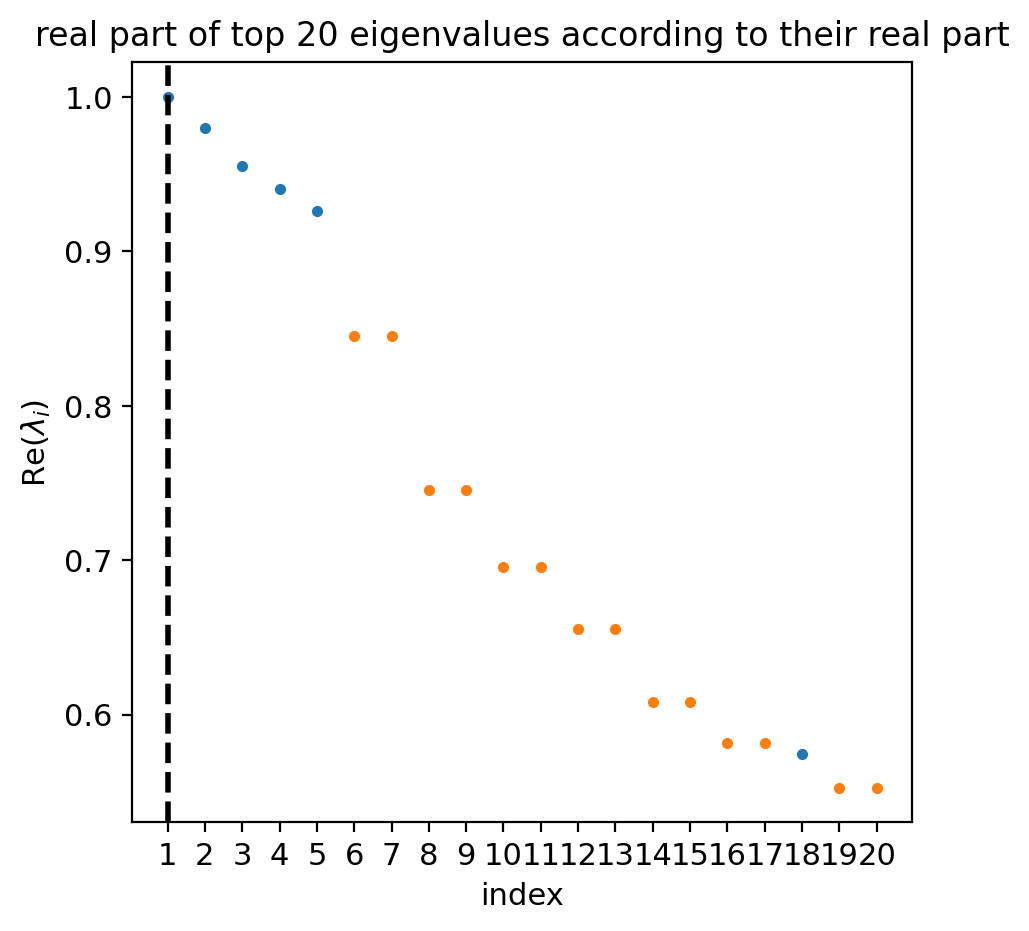

In [85]:
estimator.compute_schur(n_components=20)
if running_in_notebook():
    estimator.plot_spectrum(real_only=True)

#### Macrostates

In [86]:
estimator.compute_macrostates(n_states=18, cluster_key="cell_type")

Computing `18` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:01:08)


GPCCA[kernel=(0.8 * VelocityKernel[n=3452] + 0.2 * ConnectivityKernel[n=3452]), initial_states=None, terminal_states=None]

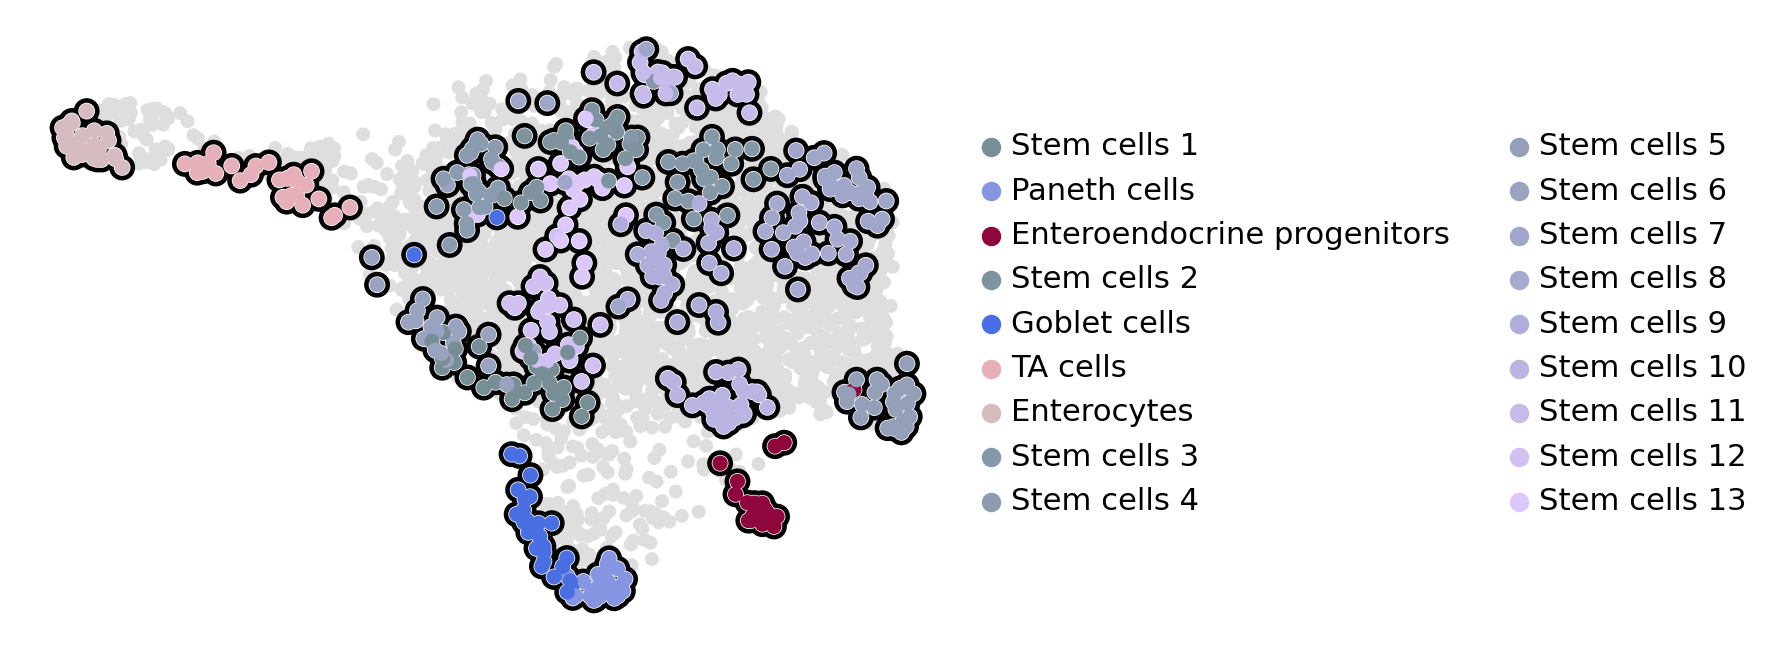

In [87]:
if running_in_notebook():
    plot_states(
        adata,
        estimator=estimator,
        which="macrostates",
        basis="umap",
        legend_loc="right",
        title="",
        size=100,
    )

    if SAVE_FIGURES:
        fpath = FIG_DIR / "labeling_kernel" / "umap_colored_by_cr_macrostates_scvelo.pdf"
        plot_states(
            adata,
            estimator=estimator,
            which="macrostates",
            basis="umap",
            legend_loc=False,
            title="",
            size=100,
            fpath=fpath,
            format="pdf",
        )

Mean purity: 0.876984126984127


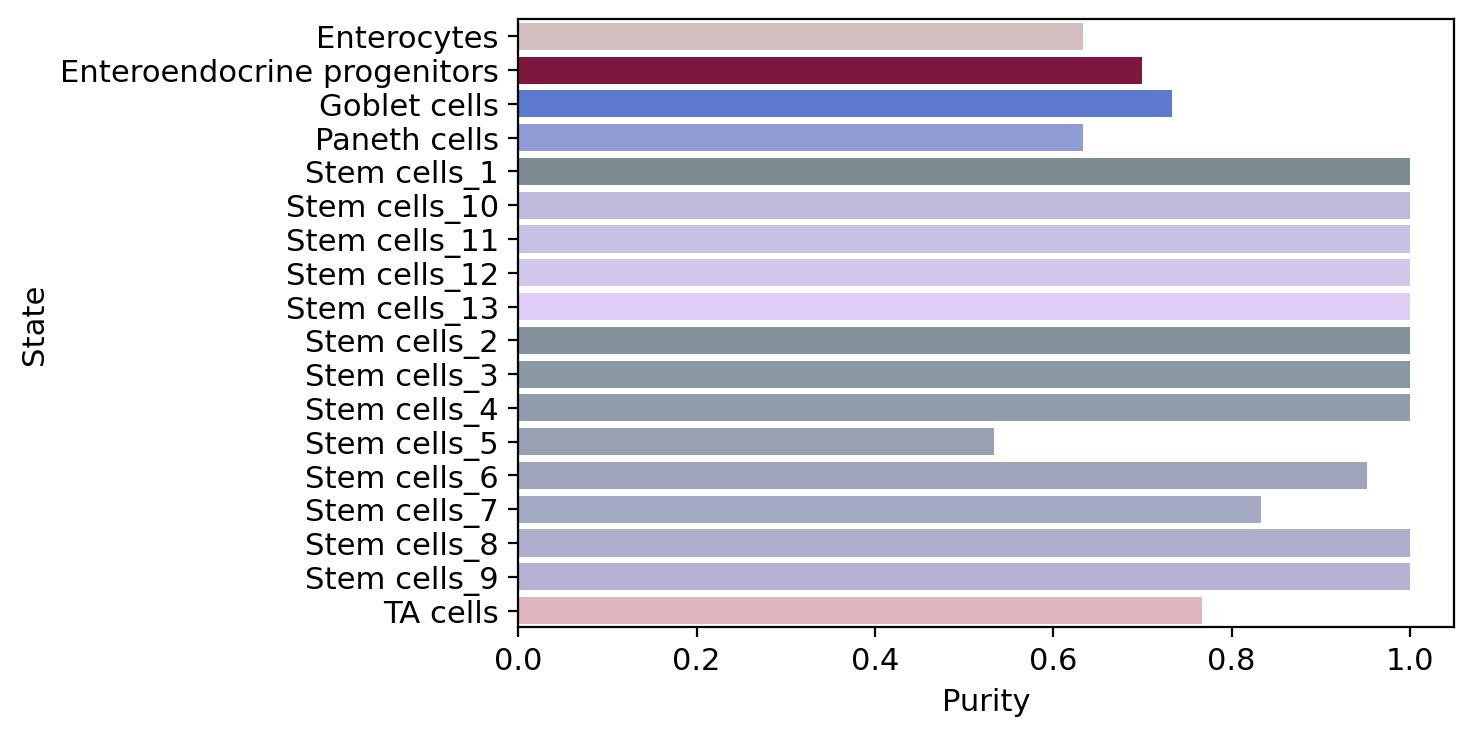

In [88]:
macrostate_purity = get_state_purity(adata, estimator, states="macrostates", obs_col="cell_type")
print(f"Mean purity: {np.mean(list(macrostate_purity.values()))}")

if running_in_notebook():
    if SAVE_FIGURES:
        fpath = FIG_DIR / "labeling_kernel" / "macrostate_purity_rna_velo.pdf"
    else:
        fpath = None

    palette = dict(zip(estimator.macrostates.cat.categories, estimator._macrostates.colors))
    order = estimator.macrostates.cat.categories.sort_values().to_list()
    plot_state_purity(macrostate_purity, palette=palette, fpath=fpath, order=order, format="eps")

In [89]:
estimator.set_terminal_states(states=["Enterocytes", "Paneth cells", "Enteroendocrine progenitors", "Goblet cells"])
terminal_states = estimator.terminal_states.cat.categories

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


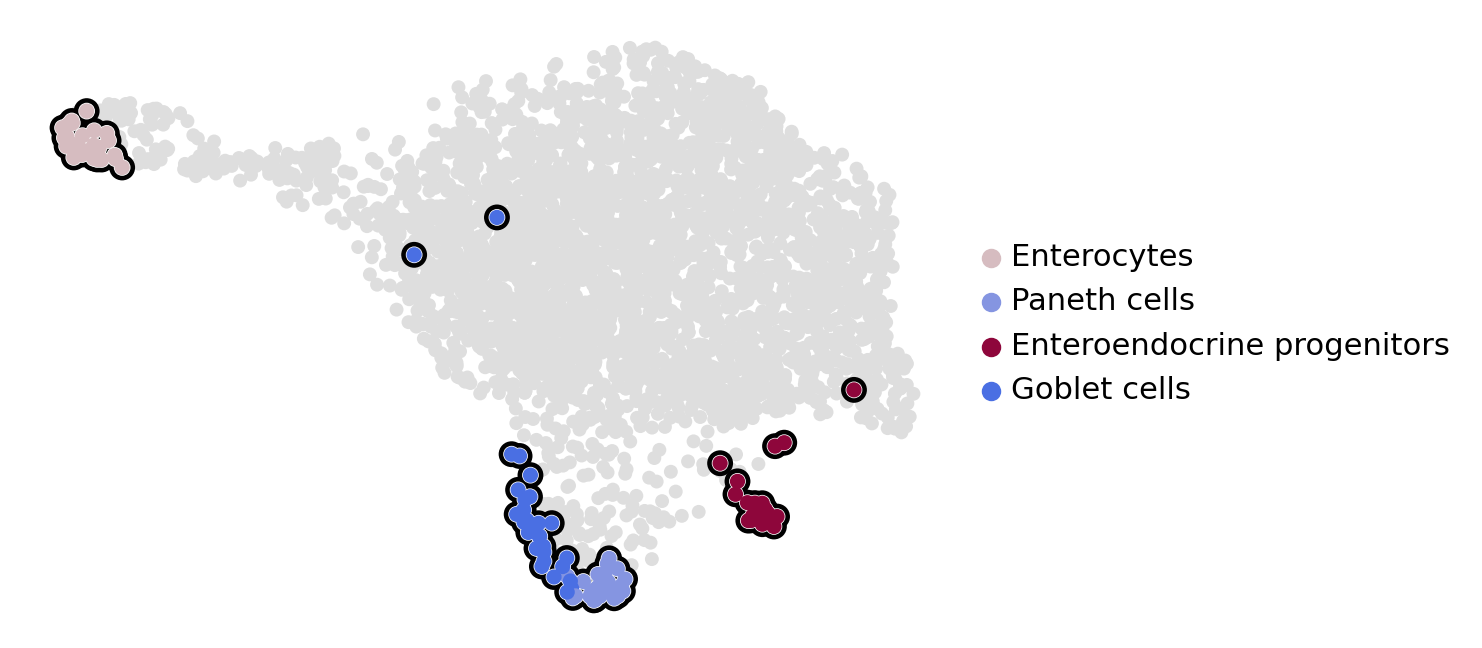

In [90]:
if running_in_notebook():
    plot_states(
        adata,
        estimator=estimator,
        which="terminal_states",
        basis="umap",
        legend_loc="right",
        title="",
        size=100,
    )

    if SAVE_FIGURES:
        fpath = FIG_DIR / "labeling_kernel" / "umap_colored_by_cr_terminal_states_scvelo.pdf"
        plot_states(
            adata,
            estimator=estimator,
            which="terminal_states",
            basis="umap",
            legend_loc=False,
            title="",
            size=100,
            fpath=fpath,
            format="pdf",
        )

Mean purity: 0.6749999999999999


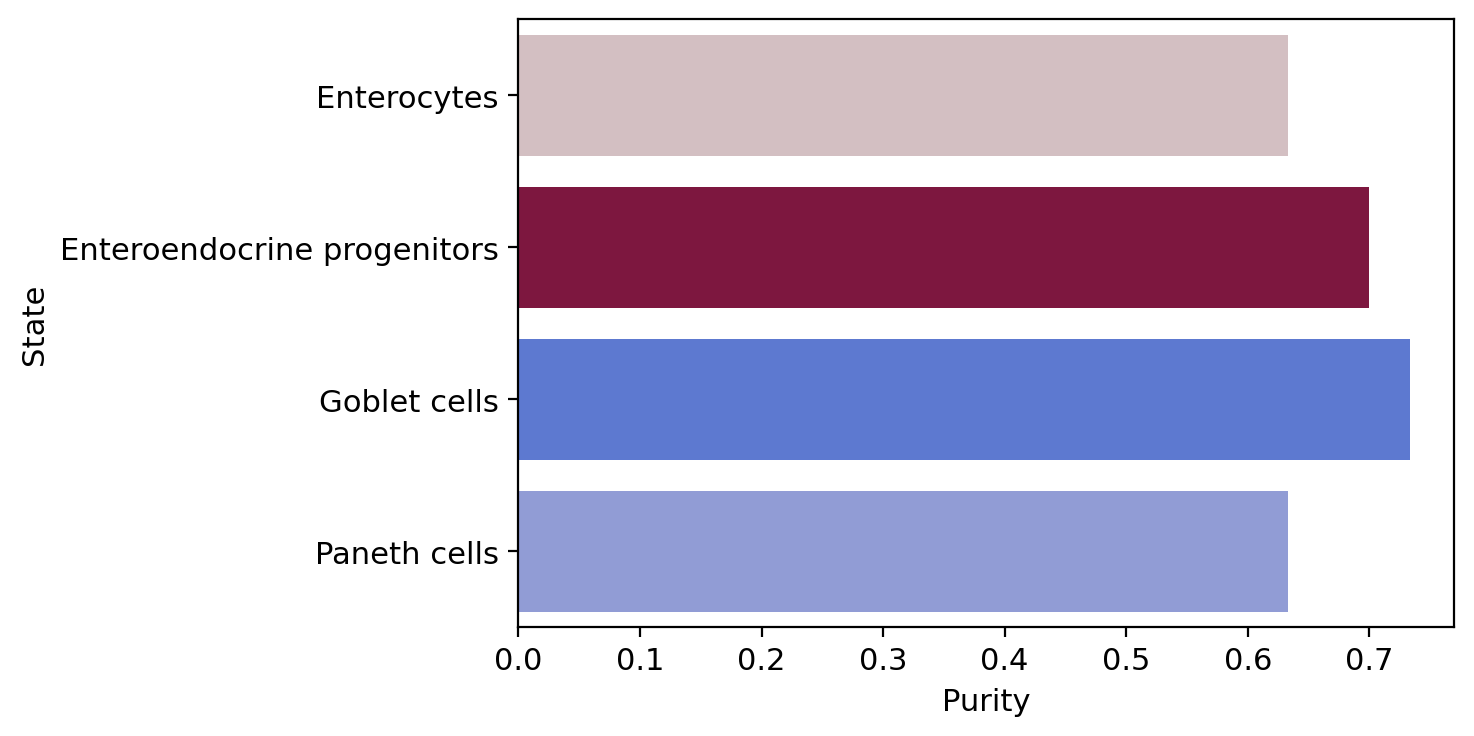

In [91]:
terminal_state_purity = get_state_purity(adata, estimator, states="terminal_states", obs_col="cell_type")
print(f"Mean purity: {np.mean(list(terminal_state_purity.values()))}")

if running_in_notebook():
    if SAVE_FIGURES:
        fpath = FIG_DIR / "labeling_kernel" / "terminal_state_purity_rna_velo.pdf"
    else:
        fpath = None

    palette = dict(zip(estimator.terminal_states.cat.categories, estimator._term_states.colors))
    order = estimator.terminal_states.cat.categories.sort_values().to_list()
    plot_state_purity(terminal_state_purity, palette=palette, order=order, fpath=fpath, format="eps")

#### Fate probabilities

In [92]:
estimator.compute_fate_probabilities()

Computing absorption probabilities


  0%|          | 0/4 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.absorption_probabilities`
    Finish (0:00:00)


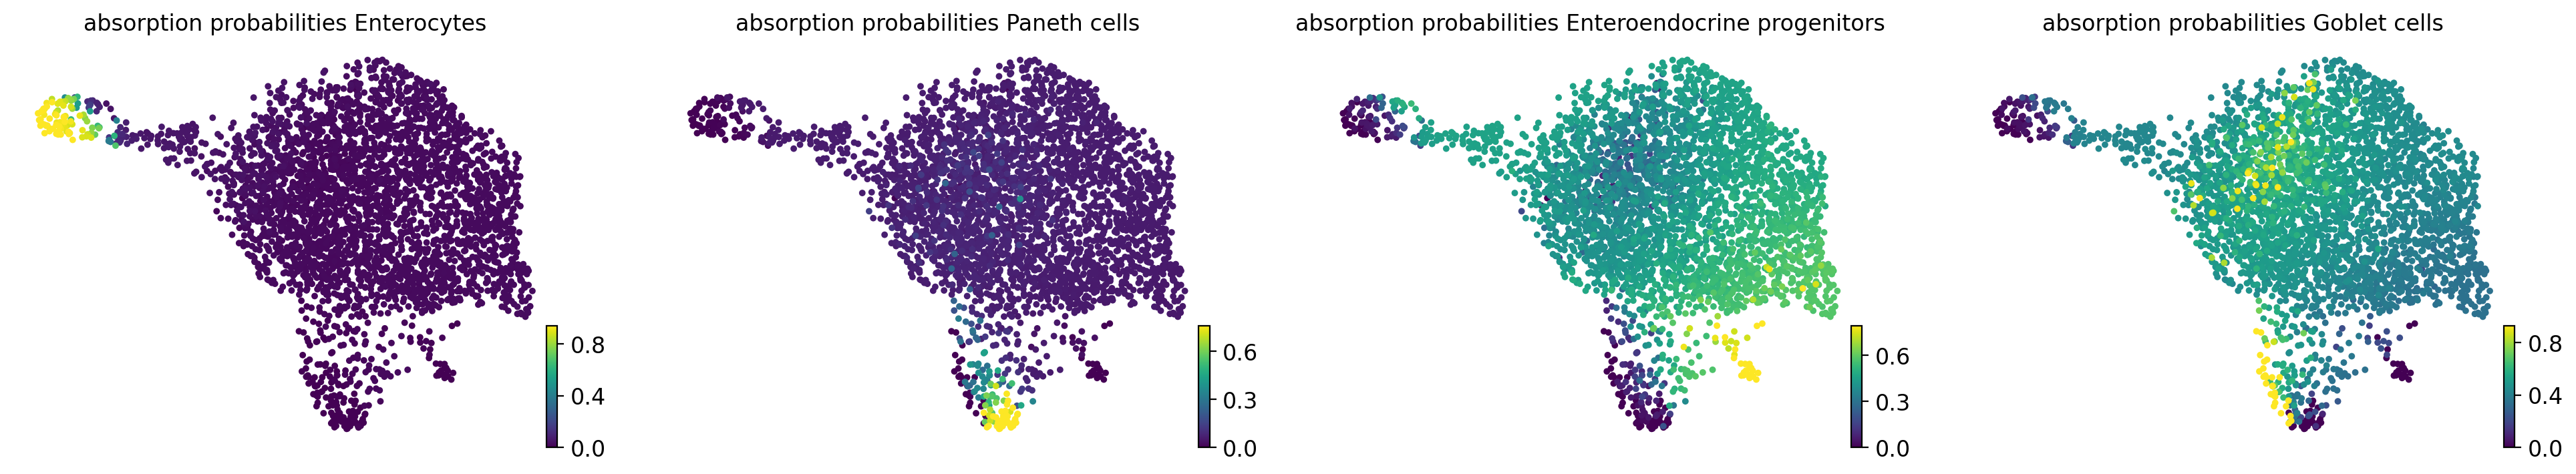

In [93]:
if running_in_notebook():
    estimator.plot_fate_probabilities(same_plot=False, size=50, basis="umap")

### Driver analysis

In [94]:
goblet_markers = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "goblet_markers.csv")["Gene"].str.lower().tolist()
)

goblet_markers = adata.var_names[adata.var_names.str.lower().isin(goblet_markers)]

In [95]:
goblet_regulators = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "goblet_regulators.csv")["Gene"].str.lower().tolist()
)

goblet_regulators = adata.var_names[adata.var_names.str.lower().isin(goblet_regulators)]

In [96]:
goblet_and_paneth_regulators = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "goblet_and_paneth_regulators.csv")["Gene"]
    .str.lower()
    .tolist()
)

goblet_and_paneth_regulators = adata.var_names[adata.var_names.str.lower().isin(goblet_and_paneth_regulators)]

In [97]:
paneth_markers = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "paneth_markers.csv")["Gene"].str.lower().tolist()
)

paneth_markers = adata.var_names[adata.var_names.str.lower().isin(paneth_markers)]

In [98]:
eec_markers = pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "eec_markers.csv")["Gene"].str.lower().tolist()

eec_markers = adata.var_names[adata.var_names.str.lower().isin(eec_markers)]

In [99]:
eec_progenitor_markers = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "eec_progenitor_markers.csv")["Gene"].str.lower().tolist()
)

eec_progenitor_markers = adata.var_names[adata.var_names.str.lower().isin(eec_progenitor_markers)]

In [100]:
enterocyte_markers = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "enterocyte_markers.csv")["Gene"].str.lower().tolist()
)

enterocyte_markers = adata.var_names[adata.var_names.str.lower().isin(enterocyte_markers)]

In [101]:
enterocyte_progenitor_markers = (
    pd.read_csv(DATA_DIR / "sceu_organoid" / "processed" / "enterocyte_progenitor_markers.csv")["Gene"]
    .str.lower()
    .tolist()
)

enterocyte_progenitor_markers = adata.var_names[adata.var_names.str.lower().isin(enterocyte_progenitor_markers)]

In [102]:
gene_ranks = {terminal_state: pd.DataFrame() for terminal_state in terminal_states}

In [103]:
drivers = estimator.compute_lineage_drivers(
    cluster_key="cell_type",
    lineages=["Enteroendocrine progenitors", "Goblet cells", "Paneth cells", "Enterocytes"],
    clusters=["Stem cells"],
    return_drivers=True,
)

for terminal_state in terminal_states:
    drivers = drivers.merge(
        pd.DataFrame(drivers.sort_values(by=f"{terminal_state}_corr", ascending=False).index)
        .reset_index()
        .rename(columns={"index": f"Corr. rank - {terminal_state}"})
        .set_index(0),
        left_index=True,
        right_index=True,
    )

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


### Goblet cells

In [104]:
_df = get_var_ranks(
    var_names=goblet_markers, drivers=drivers, macrostate="Goblet cells", var_type="Marker", model="EM Model"
)
gene_ranks["Goblet cells"] = pd.concat([gene_ranks["Goblet cells"], _df])

Marker towards Goblet cells for EM Model in top 100: 7 (out of 95)


In [105]:
_df = get_var_ranks(
    var_names=goblet_and_paneth_regulators,
    drivers=drivers,
    macrostate="Goblet cells",
    var_type="Goblet/Paneth regulator",
    model="EM Model",
)
gene_ranks["Goblet cells"] = pd.concat([gene_ranks["Goblet cells"], _df])

Goblet/Paneth regulator towards Goblet cells for EM Model in top 100: 0 (out of 3)


### Paneth cells

In [106]:
_df = get_var_ranks(
    var_names=paneth_markers, drivers=drivers, macrostate="Paneth cells", var_type="Marker", model="EM Model"
)
gene_ranks["Paneth cells"] = pd.concat([gene_ranks["Paneth cells"], _df])

Marker towards Paneth cells for EM Model in top 100: 6 (out of 18)


In [107]:
_df = get_var_ranks(
    var_names=goblet_and_paneth_regulators,
    drivers=drivers,
    macrostate="Paneth cells",
    var_type="Goblet/Paneth regulator",
    model="EM Model",
)
gene_ranks["Paneth cells"] = pd.concat([gene_ranks["Paneth cells"], _df])

Goblet/Paneth regulator towards Paneth cells for EM Model in top 100: 0 (out of 3)


### Enteroendocrine

In [108]:
_df = get_var_ranks(
    var_names=eec_markers,
    drivers=drivers,
    macrostate="Enteroendocrine progenitors",
    var_type="Marker",
    model="EM Model",
)
gene_ranks["Enteroendocrine progenitors"] = pd.concat([gene_ranks["Enteroendocrine progenitors"], _df])

Marker towards Enteroendocrine progenitors for EM Model in top 100: 12 (out of 82)


In [109]:
_df = get_var_ranks(
    var_names=eec_progenitor_markers,
    drivers=drivers,
    macrostate="Enteroendocrine progenitors",
    var_type="Progenitor marker",
    model="EM Model",
)
gene_ranks["Enteroendocrine progenitors"] = pd.concat([gene_ranks["Enteroendocrine progenitors"], _df])

Progenitor marker towards Enteroendocrine progenitors for EM Model in top 100: 1 (out of 66)


### Enterocytes

In [110]:
_df = get_var_ranks(
    var_names=enterocyte_markers, drivers=drivers, macrostate="Enterocytes", var_type="Marker", model="EM Model"
)
gene_ranks["Enterocytes"] = pd.concat([gene_ranks["Enterocytes"], _df])

Marker towards Enterocytes for EM Model in top 100: 30 (out of 170)


In [111]:
_df = get_var_ranks(
    var_names=enterocyte_progenitor_markers,
    drivers=drivers,
    macrostate="Enterocytes",
    var_type="Progenitor marker",
    model="EM Model",
)
gene_ranks["Enterocytes"] = pd.concat([gene_ranks["Enterocytes"], _df])

Progenitor marker towards Enterocytes for EM Model in top 100: 11 (out of 12)


In [112]:
for terminal_state in gene_ranks.keys():
    gene_ranks[terminal_state] = gene_ranks[terminal_state].sort_values(f"Corr. rank - {terminal_state}")
    gene_ranks[terminal_state].to_csv(
        DATA_DIR / "sceu_organoid" / "results" / f"gene_ranks_{terminal_state}-em_model.csv"
    )